### Clean all data together so that the categorical conversion is applicable.!

In [2]:
import pandas as pd
import json
from pandas import json_normalize

df=pd.read_csv(r'./feature_importance/feature_imp_data.csv',header=[0])
print(df.shape)
df.head(2)

(8244, 10)


,transmission,model,Year of Manufacture,City,ft,bt,Ownership,Kms Driven,Engine Type,price
0,1,160,2015.0,0,4,2,4,120000.0,293,400000.0
1,1,50,2018.0,0,4,7,3,32706.0,396,811000.0


In [3]:
# import numpy as np

# # Select all numeric columns including 'price'
# numeric_cols = df.select_dtypes(include=[np.number]).columns

# # Apply 3-sigma rule across all numeric columns
# for col in numeric_cols:
#     mean = df[col].mean()
#     std = df[col].std()
#     lower = mean - 3 * std
#     upper = mean + 3 * std
#     df = df[(df[col] >= lower) & (df[col] <= upper)]

# print(f"Outliers removed using 3-sigma on columns: {list(numeric_cols)}")
# print(df.shape)

In [4]:
import numpy as np

# Calculate mean and standard deviation for price
mean_price = df['price'].mean()
std_price = df['price'].std()

# Define 3-sigma bounds
lower_bound = mean_price - 3 * std_price
upper_bound = mean_price + 3 * std_price

# Filter the DataFrame to keep only rows within 3-sigma range
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

print(f"Filtered data within 3-sigma range for 'price': {lower_bound:.2f} to {upper_bound:.2f}")


Filtered data within 3-sigma range for 'price': -3273232.22 to 5191793.76


In [5]:
df_x = df.drop(columns=['price'])
df_y = df[['price']]

In [6]:
print(df_x.shape)
print(df_y.shape)

(8091, 9)
(8091, 1)


### ML model for prediction: RFR

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assume df_x (input features) and df_y (target) are already defined
# Encode any categorical variables in df_x if needed
df_x_encoded = df_x.copy()

for col in df_x_encoded.select_dtypes(include='object').columns:
    df_x_encoded[col] = LabelEncoder().fit_transform(df_x_encoded[col].astype(str))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y, test_size=0.2, random_state=42)

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.values.ravel())

# Make predictions on train and test data
train_predictions = rf.predict(X_train)
test_predictions = rf.predict(X_test)
# Calculate evaluation metrics: MAE, MSE, R-squared
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Display the metrics
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

print(f"Train R-squared: {train_r2}")
print(f"Test R-squared: {test_r2}")

Train MAE: 45426.891048889476
Test MAE: 130582.73478514074
Train MSE: 9335824836.154924
Test MSE: 70026282840.87323
Train R-squared: 0.9836561795752942
Test R-squared: 0.8896893311415519


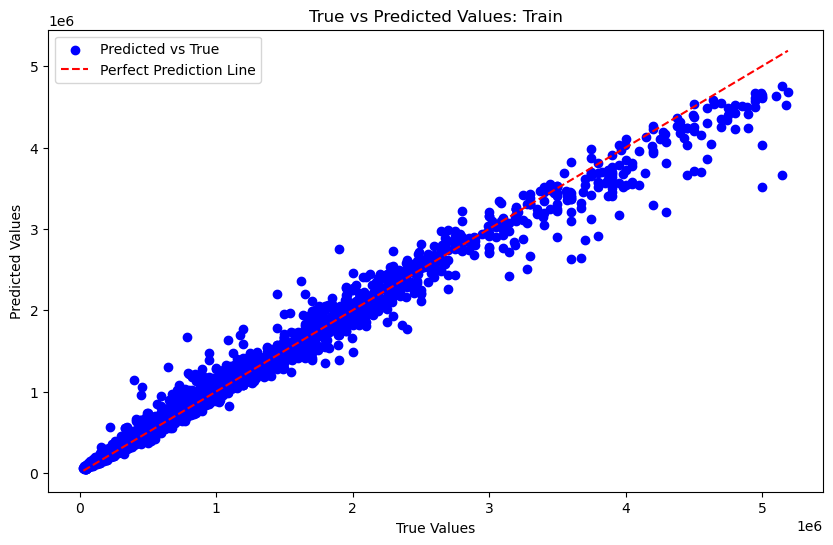

In [8]:
# Plot true vs predicted values for test set
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(y_train, train_predictions, color='blue', label='Predicted vs True')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values: Train')
plt.legend()
plt.show()

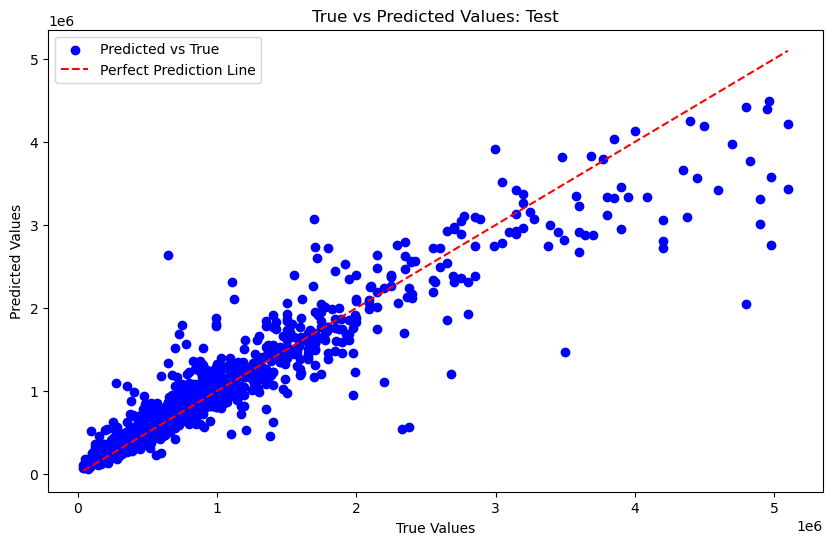

In [9]:
# Plot true vs predicted values for test set
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(y_test, test_predictions, color='blue', label='Predicted vs True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values: Test')
plt.legend()
plt.show()

### XGBoost

In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assume df_x (input features) and df_y (target) are already defined
# Encode any categorical variables in df_x if needed
df_x_encoded = df_x.copy()

for col in df_x_encoded.select_dtypes(include='object').columns:
    df_x_encoded[col] = LabelEncoder().fit_transform(df_x_encoded[col].astype(str))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train.values.ravel())

# Make predictions on train and test data
train_predictions = xgb.predict(X_train)
test_predictions = xgb.predict(X_test)

# Calculate evaluation metrics: MAE, MSE, R-squared
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Display the metrics
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

print(f"Train R-squared: {train_r2}")
print(f"Test R-squared: {test_r2}")


Train MAE: 56755.484375
Test MAE: 121628.0234375
Train MSE: 7654406656.0
Test MSE: 54198476800.0
Train R-squared: 0.9865997433662415
Test R-squared: 0.9146224856376648


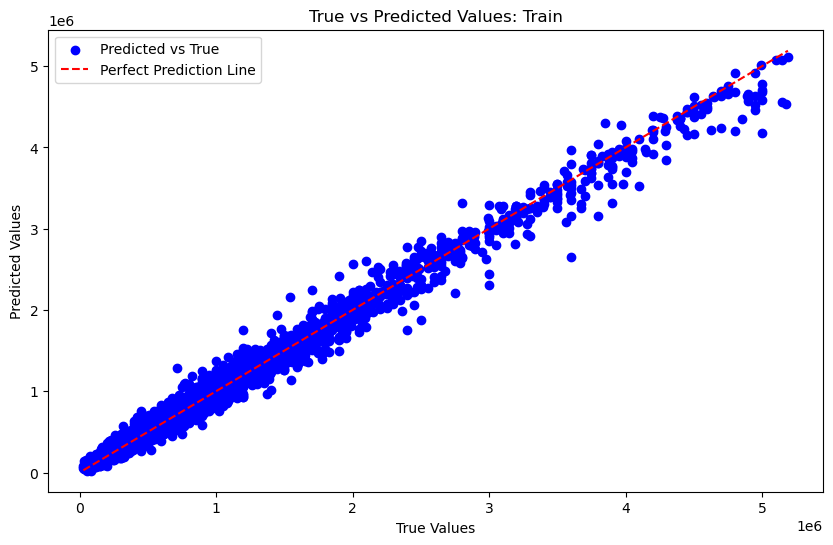

In [11]:
# Plot true vs predicted values for test set
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(y_train, train_predictions, color='blue', label='Predicted vs True')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values: Train')
plt.legend()
plt.show()

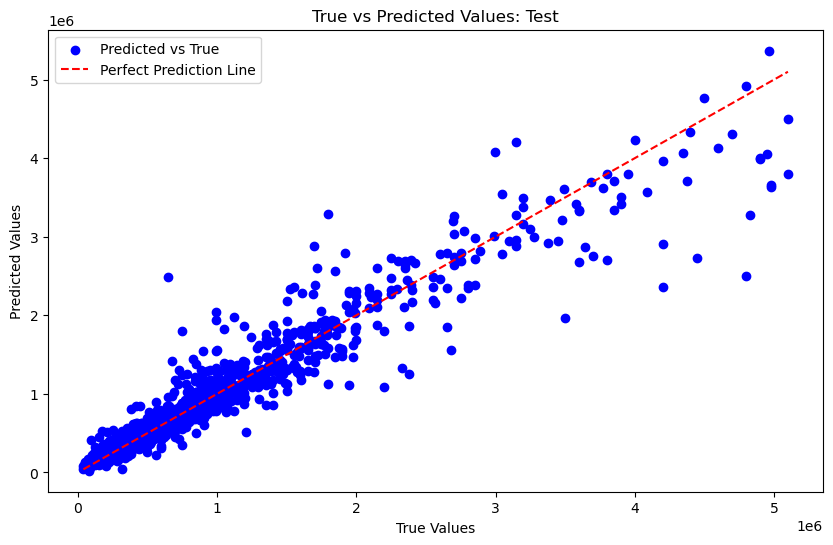

In [12]:
# Plot true vs predicted values for test set
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(y_test, test_predictions, color='blue', label='Predicted vs True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values: Test')
plt.legend()
plt.show()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Train MAE: 74912.12
Train MSE: 14975430656.00
Train R²: 0.9738

Test MAE: 123116.16
Test MSE: 52506820608.00
Test R²: 0.9173



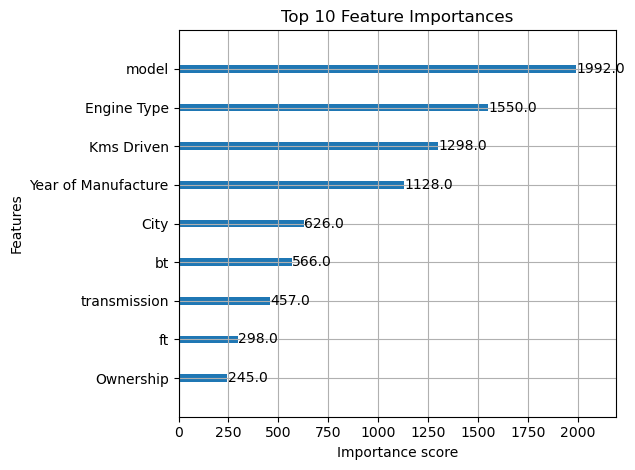

In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# ------- Assume df_x and df_y are already defined -------
df_x_encoded = df_x.copy()
for col in df_x_encoded.select_dtypes(include='object').columns:
    df_x_encoded[col] = LabelEncoder().fit_transform(df_x_encoded[col].astype(str))

X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y, test_size=0.2, random_state=42)

# --------- Random search setup ----------
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 5]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train.values.ravel())

# -------- Fit best model without early stopping --------
best_params = random_search.best_params_
final_model = XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    random_state=42
)

final_model.fit(X_train, y_train.values.ravel())  # no early stopping

# -------- Evaluation --------
def evaluate(y_true, y_pred, dataset=''):
    print(f"{dataset} MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"{dataset} MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"{dataset} R²: {r2_score(y_true, y_pred):.4f}\n")

evaluate(y_train, final_model.predict(X_train), 'Train')
evaluate(y_test, final_model.predict(X_test), 'Test')

# -------- Feature Importance --------
from xgboost import plot_importance
plot_importance(final_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Train MAE: 61288.17
Train MSE: 8247442944.00
Train R²: 0.9707

Test MAE: 84371.39
Test MSE: 21230145536.00
Test R²: 0.9218



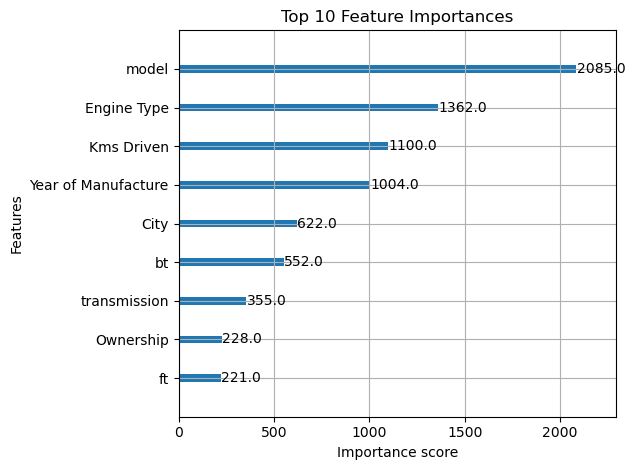

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt
import numpy as np

# ------------------- Combine & Remove Outliers -------------------
df = df_x.copy()
df['target'] = df_y.values

# Z-score method to detect outliers in target column
z_scores = (df['target'] - df['target'].mean()) / df['target'].std()
df_clean = df[np.abs(z_scores) < 3]  # keep only rows within 3 std devs

# Split back to features and target
df_x_clean = df_clean.drop(columns='target')
df_y_clean = df_clean[['target']]

# ------------------- Encode Categorical -------------------
df_x_encoded = df_x_clean.copy()
for col in df_x_encoded.select_dtypes(include='object').columns:
    df_x_encoded[col] = LabelEncoder().fit_transform(df_x_encoded[col].astype(str))

# ------------------- Train-Test Split -------------------
X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y_clean, test_size=0.2, random_state=42)

# ------------------- Hyperparameter Tuning -------------------
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 5]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train.values.ravel())

# ------------------- Final Model -------------------
best_params = random_search.best_params_
final_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
final_model.fit(X_train, y_train.values.ravel())

# ------------------- Evaluation -------------------
def evaluate(y_true, y_pred, dataset=''):
    print(f"{dataset} MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"{dataset} MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"{dataset} R²: {r2_score(y_true, y_pred):.4f}\n")

evaluate(y_train, final_model.predict(X_train), 'Train')
evaluate(y_test, final_model.predict(X_test), 'Test')

# ------------------- Feature Importance -------------------
plot_importance(final_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# ------------------- Apply Log Transformation to Target -------------------
df = df_x.copy()
df['target'] = df_y.values

# Apply log1p (log(1 + x)) to the target to handle skewness
df['target'] = np.log1p(df['target'])  

# Split back to features and target
df_x_clean = df.drop(columns='target')
df_y_clean = df[['target']]

# ------------------- Encode Categorical Features -------------------
df_x_encoded = df_x_clean.copy()
for col in df_x_encoded.select_dtypes(include='object').columns:
    df_x_encoded[col] = LabelEncoder().fit_transform(df_x_encoded[col].astype(str))

# ------------------- Train-Test Split -------------------
X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y_clean, test_size=0.2, random_state=42)

# ------------------- Hyperparameter Tuning -------------------
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 5, 10, 50]
}


random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train.values.ravel())

# ------------------- Final Model -------------------
best_params = random_search.best_params_
final_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
final_model.fit(X_train, y_train.values.ravel())

# ------------------- Predictions -------------------
# Make predictions on test data
y_pred_log = final_model.predict(X_test)

# Apply expm1 to revert log1p transformation to original scale
y_pred = np.expm1(y_pred_log)  # Inverse of log1p

# ------------------- Evaluation -------------------
def evaluate(y_true, y_pred, dataset=''):
    print(f"{dataset} MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"{dataset} MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"{dataset} R²: {r2_score(y_true, y_pred):.4f}\n")

evaluate(np.expm1(y_test), y_pred, 'Test')  # Inverse log1p for true test values as well

import pickle
# ------------------- Save Model as Pickle -------------------
with open('car_price_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("Model saved as 'car_price_model.pkl'")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Test MAE: 115054.43
Test MSE: 54336606208.00
Test R²: 0.9144



Fitting 3 folds for each of 10 candidates, totalling 30 fits


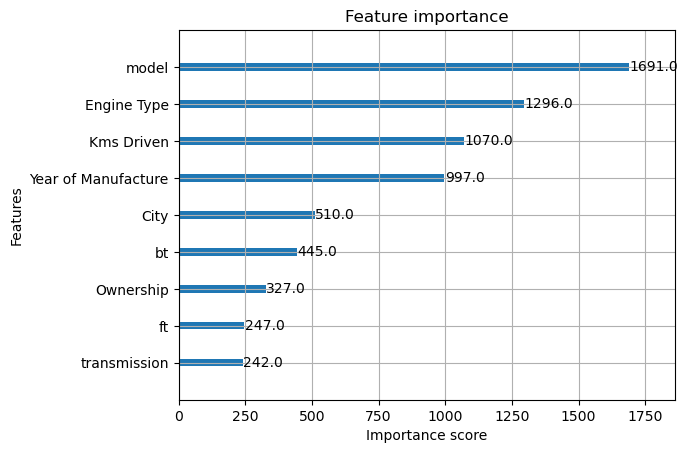

XGBoost Test MAE: 118189.73
XGBoost Test MSE: 57552834560.00
XGBoost Test R²: 0.9093

Stacked Model Test MAE: 117962.89
Stacked Model Test MSE: 57088464039.38
Stacked Model Test R²: 0.9101

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 6472, number of used features: 9
[LightGBM] [Info] Start training from score 13.327007
LightGBM Test MAE: 112646.21
LightGBM Test MSE: 57905513362.44
LightGBM Test R²: 0.9088



In [24]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

# ------------------- Apply Log Transformation to Target -------------------
df = df_x.copy()
df['target'] = df_y.values

# Apply log1p (log(1 + x)) to the target to handle skewness
df['target'] = np.log1p(df['target'])  

# Split back to features and target
df_x_clean = df.drop(columns='target')
df_y_clean = df[['target']]

# ------------------- Encode Categorical Features -------------------
df_x_encoded = df_x_clean.copy()
for col in df_x_encoded.select_dtypes(include='object').columns:
    df_x_encoded[col] = LabelEncoder().fit_transform(df_x_encoded[col].astype(str))

# ------------------- Train-Test Split -------------------
X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y_clean, test_size=0.2, random_state=42)

# ------------------- Hyperparameter Tuning -------------------
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Expanding the hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [3, 5, 7, 9, 12],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1, 5, 10]
}

# Running RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train.values.ravel())

# ------------------- Final Model -------------------
best_params = random_search.best_params_
final_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
final_model.fit(X_train, y_train.values.ravel())

# ------------------- Feature Importance -------------------
# Plot feature importance to check the most relevant features
import xgboost as xgb

# Plot feature importance using xgboost's plot_importance function
xgb.plot_importance(final_model, importance_type='weight', max_num_features=10)
plt.show()


# ------------------- Stacking Model -------------------
# Create a stacking regressor combining XGBoost and Linear Regression
stack_model = StackingRegressor(
    estimators=[('xgb', final_model), ('lr', LinearRegression())],
    final_estimator=LinearRegression()
)
stack_model.fit(X_train, y_train.values.ravel())

# ------------------- Predictions -------------------
# Make predictions with the final model and the stacked model
y_pred_log = final_model.predict(X_test)
stack_preds = stack_model.predict(X_test)

# Apply expm1 to revert log1p transformation to original scale
y_pred = np.expm1(y_pred_log)  # Inverse of log1p
stack_preds = np.expm1(stack_preds)

# ------------------- Evaluation -------------------
def evaluate(y_true, y_pred, dataset=''):
    print(f"{dataset} MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"{dataset} MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"{dataset} R²: {r2_score(y_true, y_pred):.4f}\n")

# Evaluate the model and stacking model
evaluate(np.expm1(y_test), y_pred, 'XGBoost Test')
evaluate(np.expm1(y_test), stack_preds, 'Stacked Model Test')

# ------------------- LightGBM Model -------------------
# LightGBM as an alternative model to compare
lgb_model = LGBMRegressor(n_estimators=1000, learning_rate=0.05)
lgb_model.fit(X_train, y_train.values.ravel())
lgb_preds = lgb_model.predict(X_test)

# Evaluate LightGBM
evaluate(np.expm1(y_test), np.expm1(lgb_preds), 'LightGBM Test')
